In [1]:
import ds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.colors import ListedColormap
import math
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv("Cleaned_DF.csv")
df.drop("Unnamed: 0", axis = 1, inplace = True)

In [2]:
mask1 = (df['CryoSleep']==0)&(df['Age']>12.5)
features = ['Age','VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Deck','Num','Side','route']
dz = df[mask1][features+["Transported"]]
dz.shape

(4447, 12)

LDA

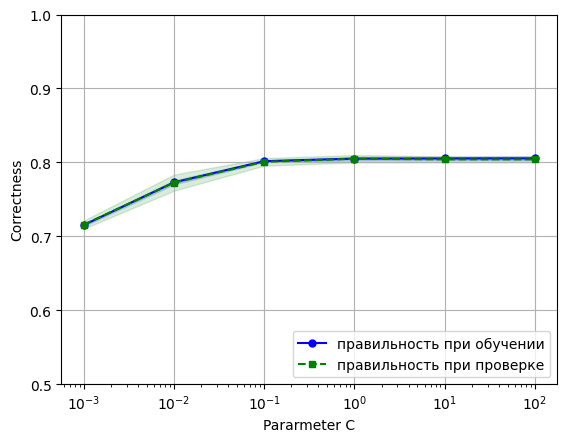

0.7955056179775281

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve

X_train, X_test, y_train, y_test = train_test_split(dz[features],dz["Transported"],test_size =0.2, stratify = dz["Transported"], random_state = 1)

#pipe_lr = make_pipeline(StandardScaler(),LogisticRegression(penalty = 'l2',random_state = 1,solver = 'lbfgs', max_iter = 1000))
#pipe_tree = make_pipeline(StandardScaler(),ds.LDA(plot = False),DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=1))

#estimators = [
#    ('Logistic Regression on full space', pipe_lr),                       
#    ('Tree on LDA space', pipe_tree)
#]

#final_estimator = LogisticRegression(penalty = 'l2',random_state = 1,solver = 'lbfgs', max_iter = 1000)#DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=1)

#pipe = StackingClassifier(estimators=estimators, final_estimator = final_estimator,passthrough = False)

pipe = make_pipeline(StandardScaler(),LogisticRegression(penalty = 'l2',random_state = 1,solver = 'lbfgs', max_iter = 1000))

#scores = cross_val_score(estimator = pipe,X = X_train, y = y_train, cv = 5, n_jobs = 1)
param_range = [0.001, 0.01, 0.1, 1, 10, 100]
train_scores, test_scores = validation_curve(estimator = pipe, X = X_train, y = y_train, param_name = 'logisticregression__C',param_range = param_range, cv = 5)

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.plot(param_range, train_mean, color = 'blue', marker = 'o', markersize = 5, label = 'правильность при обучении')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha = 0.15, color='blue')

plt.plot(param_range, test_mean, color = 'green', linestyle = '--', marker = 's', markersize = 5, label = 'правильность при проверке')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha = 0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc = 'lower right')
plt.xlabel('Pararmeter C')
plt.ylabel('Correctness')
plt.ylim([0.5,1.0])
plt.show()


#print('Precision cross  validation: %.3f +/- %.3f'%(np.mean(scores), np.std(scores)))

pipe_knn = pipe.fit(X_train,y_train)
pipe.score(X_test,y_test)


In [115]:
score = 0
for i in range(30):
    df_train = df.sample(random_state = i, frac = 0.8)
    df_test = df.drop(df_train.index)

    pipe_knn = make_pipeline(Row_selector((df['CryoSleep']==0)&(df['Age']>12.5)), StandardScaler(),ds.LDA(plot=False),KNeighborsClassifier(n_neighbors =20, p=1,weights ='uniform'))
    pipe_tree = make_pipeline(Row_selector((df['CryoSleep']==0)&(df['Age']>12.5)), StandardScaler(),ds.LDA(plot=False),DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1))

    estimators = [
        ('knn pipeline', pipe_knn),                       
        ('tree pipeline', pipe_tree)
    ]

    final_estimator = LogisticRegression()
    #DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1)#DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=1)#SVC(kernel = 'rbf', random_state = 1, gamma = 10, C =100)

    pipe = StackingClassifier(estimators=estimators, final_estimator = final_estimator,passthrough = True)
    pipe = pipe.fit(df_train[features],df_train["Transported"])
    score +=pipe.score(df_test[features],df_test["Transported"])
score /=30
score

C:\Users\Сергей\AppData\Local\Temp\ipykernel_13220\4068134040.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[self.mask_fit]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 3534 but corresponding boolean dimension is 6139

In [37]:
mask2 = (df['CryoSleep']==1)|(df['Age']<=12.5)
df_rest = df[mask2]
df_rest.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,route
count,3227.000000,3227.000000,3227.000000,3227.0,3227.0,3227.0,3227.0,3227.0,3227.000000,3227.000000,3227.000000,3227.000000,3227.000000
mean,0.888131,24.850635,0.006508,0.0,0.0,0.0,0.0,0.0,0.606446,5.464208,589.664704,1.519058,4.223737
std,0.315254,15.956213,0.080419,0.0,0.0,0.0,0.0,0.0,0.795248,1.954902,488.612792,0.499714,2.410741
min,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,14.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,4.000000,169.500000,1.000000,2.000000
50%,1.000000,24.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,6.000000,445.000000,2.000000,4.000000
75%,1.000000,35.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,974.000000,2.000000,7.000000
max,1.000000,78.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,1888.000000,2.000000,9.000000


In [38]:
df_rest.drop(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],axis = 1, inplace = True)

C:\Users\Сергей\AppData\Local\Temp\ipykernel_13220\1175330434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rest.drop(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],axis = 1, inplace = True)


In [39]:
pd.value_counts(df_rest[df_rest["route"]>3.5]["Transported"])

 1.0    1554
-1.0      67
Name: Transported, dtype: int64

if "route">3.5 and ('CryoSleep'==1 or 'Age'<=12.5) ==> assign 1

In [40]:
mask3 = ((df['CryoSleep']==1)|(df['Age']<=12.5))&(df['route']<=3.5)
df_rest2 = df[mask3]
df_rest2.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,route
count,1606.000000,1606.000000,1606.0,1606.0,1606.0,1606.0,1606.0,1606.0,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000
mean,0.839352,20.279577,0.0,0.0,0.0,0.0,0.0,0.0,0.292653,6.947073,734.965131,1.504359,2.058531
std,0.367320,15.252832,0.0,0.0,0.0,0.0,0.0,0.0,0.956517,0.340881,442.836016,0.500137,0.625770
min,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,7.000000,342.500000,1.000000,2.000000
50%,1.000000,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,729.500000,2.000000,2.000000
75%,1.000000,29.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,1092.000000,2.000000,2.000000
max,1.000000,78.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,1808.000000,2.000000,3.000000


In [41]:
df_rest2.drop(['VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],axis = 1, inplace = True)

C:\Users\Сергей\AppData\Local\Temp\ipykernel_13220\1254796416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rest2.drop(['VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],axis = 1, inplace = True)


In [42]:
mask_disaster = (df['Num']>764)&(df['Num']<=1203)&(df['Side']==2)
print(pd.value_counts(df_rest2[mask_disaster]["Transported"]))

 1.0    221
-1.0      3
Name: Transported, dtype: int64


C:\Users\Сергей\AppData\Local\Temp\ipykernel_13220\298909557.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(pd.value_counts(df_rest2[mask_disaster]["Transported"]))


if mask3 & mask disaster ==> assign 1

In [43]:
mask4 = mask3&(~mask_disaster)
df_final =df[mask4]
df_final.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,route
count,1382.000000,1382.000000,1382.0,1382.0,1382.0,1382.0,1382.0,1382.0,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000
mean,0.835022,20.203329,0.0,0.0,0.0,0.0,0.0,0.0,0.182344,6.942113,696.259768,1.424023,2.069465
std,0.371295,15.208754,0.0,0.0,0.0,0.0,0.0,0.0,0.983591,0.362397,463.645249,0.494373,0.624929
min,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,7.000000,288.250000,1.000000,2.000000
50%,1.000000,18.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,630.000000,1.000000,2.000000
75%,1.000000,28.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,1126.500000,2.000000,2.000000
max,1.000000,78.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,1808.000000,2.000000,3.000000


In [44]:
df_final.drop(['VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],axis = 1, inplace = True)

C:\Users\Сергей\AppData\Local\Temp\ipykernel_13220\3207362834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.drop(['VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],axis = 1, inplace = True)


In [46]:
df_final.describe()

,CryoSleep,Age,Transported,Deck,Num,Side,route
count,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000
mean,0.835022,20.203329,0.182344,6.942113,696.259768,1.424023,2.069465
std,0.371295,15.208754,0.983591,0.362397,463.645249,0.494373,0.624929
min,0.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,8.000000,-1.000000,7.000000,288.250000,1.000000,2.000000
50%,1.000000,18.500000,1.000000,7.000000,630.000000,1.000000,2.000000
75%,1.000000,28.000000,1.000000,7.000000,1126.500000,2.000000,2.000000
max,1.000000,78.000000,1.000000,7.000000,1808.000000,2.000000,3.000000


Let's do LDA again

In [61]:
features = ['Age','CryoSleep','Num','Side','route','Deck']


score = 0
for i in range(30):

    df_final_train = df_final.sample(random_state = i, frac = 0.8)
    df_final_test = df_final.drop(df_final_train.index)

    pipe_knn = make_pipeline(StandardScaler(),ds.LDA(plot=False),KNeighborsClassifier(n_neighbors =2, p=1,weights ='uniform'))
    pipe_tree = make_pipeline(StandardScaler(),ds.LDA(plot=False),DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1))

    estimators = [
        ('knn pipeline', pipe_knn),                       
        ('tree pipeline', pipe_tree)
    ]

    final_estimator = LogisticRegression()#DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1)
    #LogisticRegression()#DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1)#DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=1)#SVC(kernel = 'rbf', random_state = 1, gamma = 10, C =100)

    pipe = StackingClassifier(estimators=estimators, final_estimator = final_estimator,passthrough = False)
    pipe = pipe.fit(df_final_train[features],df_final_train["Transported"])
    score +=pipe.score(df_final_test[features],df_final_test["Transported"])
score /=30
score

0.583816425120773

In [63]:
pipe_tree.fit(df_final_train[features],df_final_train["Transported"])
pipe_tree.score(df_final_test[features],df_final_test["Transported"])

0.5579710144927537

In [68]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1)
tree = tree.fit(df_final_train[features],df_final_train["Transported"])
tree.score(df_final_test[features],df_final_test["Transported"])

0.572463768115942